# EEG Analysis
#### Methods in CSS 23/24; Jelmer Borst (j.p.borst@rug.nl)

To analyze the EEG data, we will use [MNE](https://mne.tools/stable/index.html) in Python. 

For every project that you do in Python, I would advise you to make a new [Anaconda](https://www.anaconda.com) environment for two reasons:
1) you don't run into compatibility problems with libraries between projects.
2) you can still run your analysis/project when coming back to it later, without having to update your code to the latest versions.

For this analysis, you only need MNE (and jupyterlab), so you could create an environment like:

```
conda create -n eeg_analysis pip
conda activate eeg_analysis  
pip install mne jupyterlab PyQt5 scikit-learn pandas
```

In this notebook, I will explain preprocessing and making ERPs. However, I would also advise you to take a look a the introductory tutorial of MNE, which also goes through these steps and provides quite some explanation and links to more detailed sections: https://mne.tools/stable/auto_tutorials/intro/10_overview.html.

The code deals with a Biosemi datafile recorded in our lab of a lexical decision experiment (see also the example opensesame file on Brightspace). You can download a zip archive from Brightspace (it's rather big). The zip file contains:
- this notebook
- an EEG dataset of one subject
- a pre-processed behavioral data file of the same subject


## Preprocessing

The first step in EEG analysis is to preprocess the data. This consists of four general steps:
1. Reading in the data, re-referencing, and filtering.
2. Visual artifact inspection.
3. Independent Component Analysis to remove eye blinks and movements.
4. Epoching and baselining

However, first we set up our environment:

In [1]:
import mne # preprocessing and plotting
import numpy as np # numerical computations
import matplotlib.pyplot as plt # plotting

# plot within notebook, useful for later sharing
%matplotlib inline 

EEG_data_path = './data/' # might be different on Windows
name_subj = "1"

### Reading data, referencing, and filtering

The data in `data/EEG_subject-1.bdf` were recorded on the same Biosemi system that you will use, with 32 channels. First, we read in the data.

In [2]:
raw = mne.io.read_raw_bdf(EEG_data_path + 'EEG_subject-%s.bdf' % name_subj, preload=True, verbose=True)

Extracting EDF parameters from /Users/Jelmer/Work/Vakken/MethodsCCS/MethodsCCS_2324/EEG/python_example/data/EEG_subject-1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 948735  =      0.000 ...  1852.998 secs...


We check `raw.info`, which contains information on the recordings. We see that there are 47 EEG channels and one stimulus channel (containing the triggers). Apparently, there are no EOG (eye) channels. The recording frequency was 512 Hz.

In [3]:
raw.info 

<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 47 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2019-05-17 09:23:26 UTC
 nchan: 48
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>

Let's check which channels those 47 are:

In [4]:
print(raw.info.ch_names)

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp', 'Status']


These are the electrodes in the EEG cap, the external electrodes (including the mastoids EXG5 and EXG6) and a couple of empty channels. We use the mastoids to rereference the data (serve as ground), and then remove all extra channels.

In [5]:
#rereference the data to the average of the mastoids
raw.set_eeg_reference(ref_channels=['EXG5','EXG6'])

#drop empty channels and mastoids
raw.drop_channels(['EXG5', 'EXG6','EXG7','EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawEDF | EEG_subject-1.bdf, 37 x 948736 (1853.0 s), ~267.8 MB, data loaded>

Now we have 36 channels left: 32 EEG and 4 externals. Those 4 external channels are the horizontal and vertical eye electrodes. We use these to create EOG (eye) channels.

In [6]:
#create bipolar eye channels and set type
mne.set_bipolar_reference(raw,anode=['EXG1','EXG3'],cathode=['EXG2','EXG4'],ch_name=['EOGH','EOGV'], copy=False)
raw.set_channel_types({'EOGH':'eog','EOGV':'eog'})

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=2, n_times=948736
    Range : 0 ... 948735 =      0.000 ...  1852.998 secs
Ready.
Added the following bipolar channels:
EOGH, EOGV


<RawEDF | EEG_subject-1.bdf, 35 x 948736 (1853.0 s), ~253.4 MB, data loaded>

At this point we're left with the 32 channels we expected at the start. The next step is to tell MNE what the position of these channels is. To do this, we first have to rename the numbered channels (A1, A2, etc) to standard EEG 10/20 names (Fp1, Fp2, etc). Next we tell MNE that we have a biosemi system, and plot the result.

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


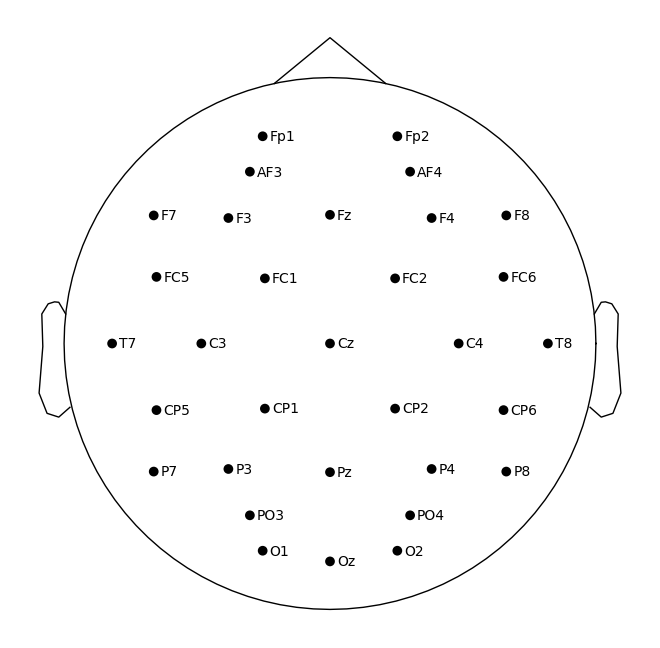

In [7]:
#add channel locations
#first rename to standard 10/20 names
dict_to_biosemi = dict(zip(raw.copy().pick_types(eeg=True).ch_names, mne.channels.make_standard_montage('biosemi32').ch_names))#convert names to biosemi 32 frame
raw.rename_channels(dict_to_biosemi)
#set montage
raw.set_montage('biosemi32')
raw.plot_sensors(show_names=True);

The next step is to filter the data. Let's first look at what we have:

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)


/Users/Jelmer/miniconda3/envs/eeg_analysis/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


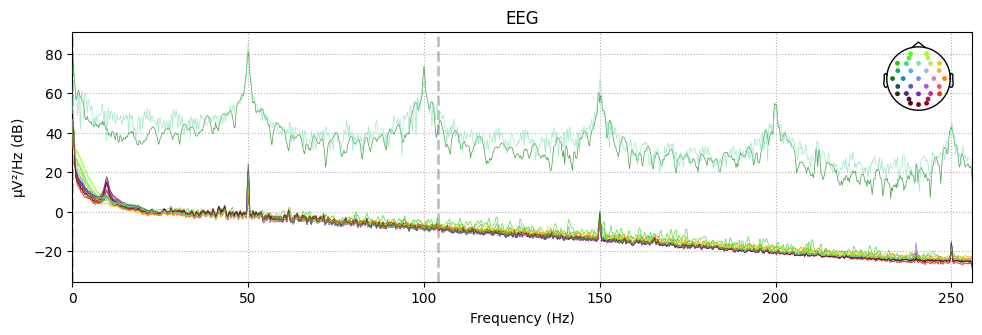

In [8]:
raw.plot_psd(picks='eeg');

We see that we have two slightly weird channels with much higher amplitudes. In addition, we see a clear peak at 50 hz due to the mains power. To avoid this, we are going to filter between 1 and 40Hz.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)


/Users/Jelmer/miniconda3/envs/eeg_analysis/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


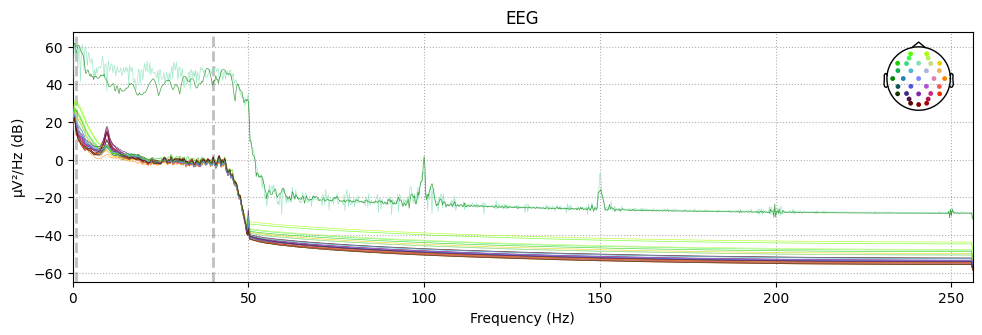

In [9]:
raw.filter(l_freq=1, h_freq=40)
raw.plot_psd(picks='eeg');

Next, we need to read in the triggers we sent with Opensesame as MNE `events` and and them as `annotations` to the data, so we can see them when we look at the data in a moment. At some point it might be useful to learn more about events, see this tutorial: https://mne.tools/stable/auto_tutorials/intro/20_events_from_raw.html.

In [10]:
#Find events in stimulus channel
events = mne.find_events(raw) # MNE automatically recognizes Biosemi triggers

#add labels to events. 
event_dict = {  "practice_start": 3,
                "block_start": 4, 
                "practice_end"
                "block_end": 6,
                "fix_HF": 51,
                "fix_LF": 52,
                "fix_pseudo": 53,
                "fix_random": 54,
                "stim_HF": 11,
                "stim_LF": 12,
                "stim_pseudo": 13,
                "stim_random": 14,
                "resp_corr_HF": 21,
                "resp_corr_LF": 22,
                "resp_corr_pseudo": 23,
                "resp_corr_random": 24,
                "resp_incorr_HF": 31,
                "resp_incorr_LF": 32,
                "resp_incorr_pseudo": 33,
                "resp_incorr_random": 34,
                "resp_none_HF": 41,
                "resp_none_LF": 42,
                "resp_none_pseudo": 43,
                "resp_none_random": 44,
                }
event_dict_rev = {v: k for k, v in event_dict.items()}

#and set as annotations - neat for plotting
annot_from_events = mne.annotations_from_events(
    events = events,
    event_desc = event_dict_rev,
    sfreq = raw.info['sfreq'])
raw.set_annotations(annot_from_events);

#drop stim channel
raw.drop_channels(['Status']);

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
2914 events found
Event IDs: [ 3  4  5  6 11 12 13 14 21 22 23 24 31 32 33 34 41 42 43 51 52 53 54]


Now we can finally plot the data to see what it looks like. When running it on your own computer, set `matplotlib qt` to get an interactive plot. Thevertical lines are the triggers. You can nicely see the eye blinks, especially in frontal channels.

Using matplotlib as 2D backend.


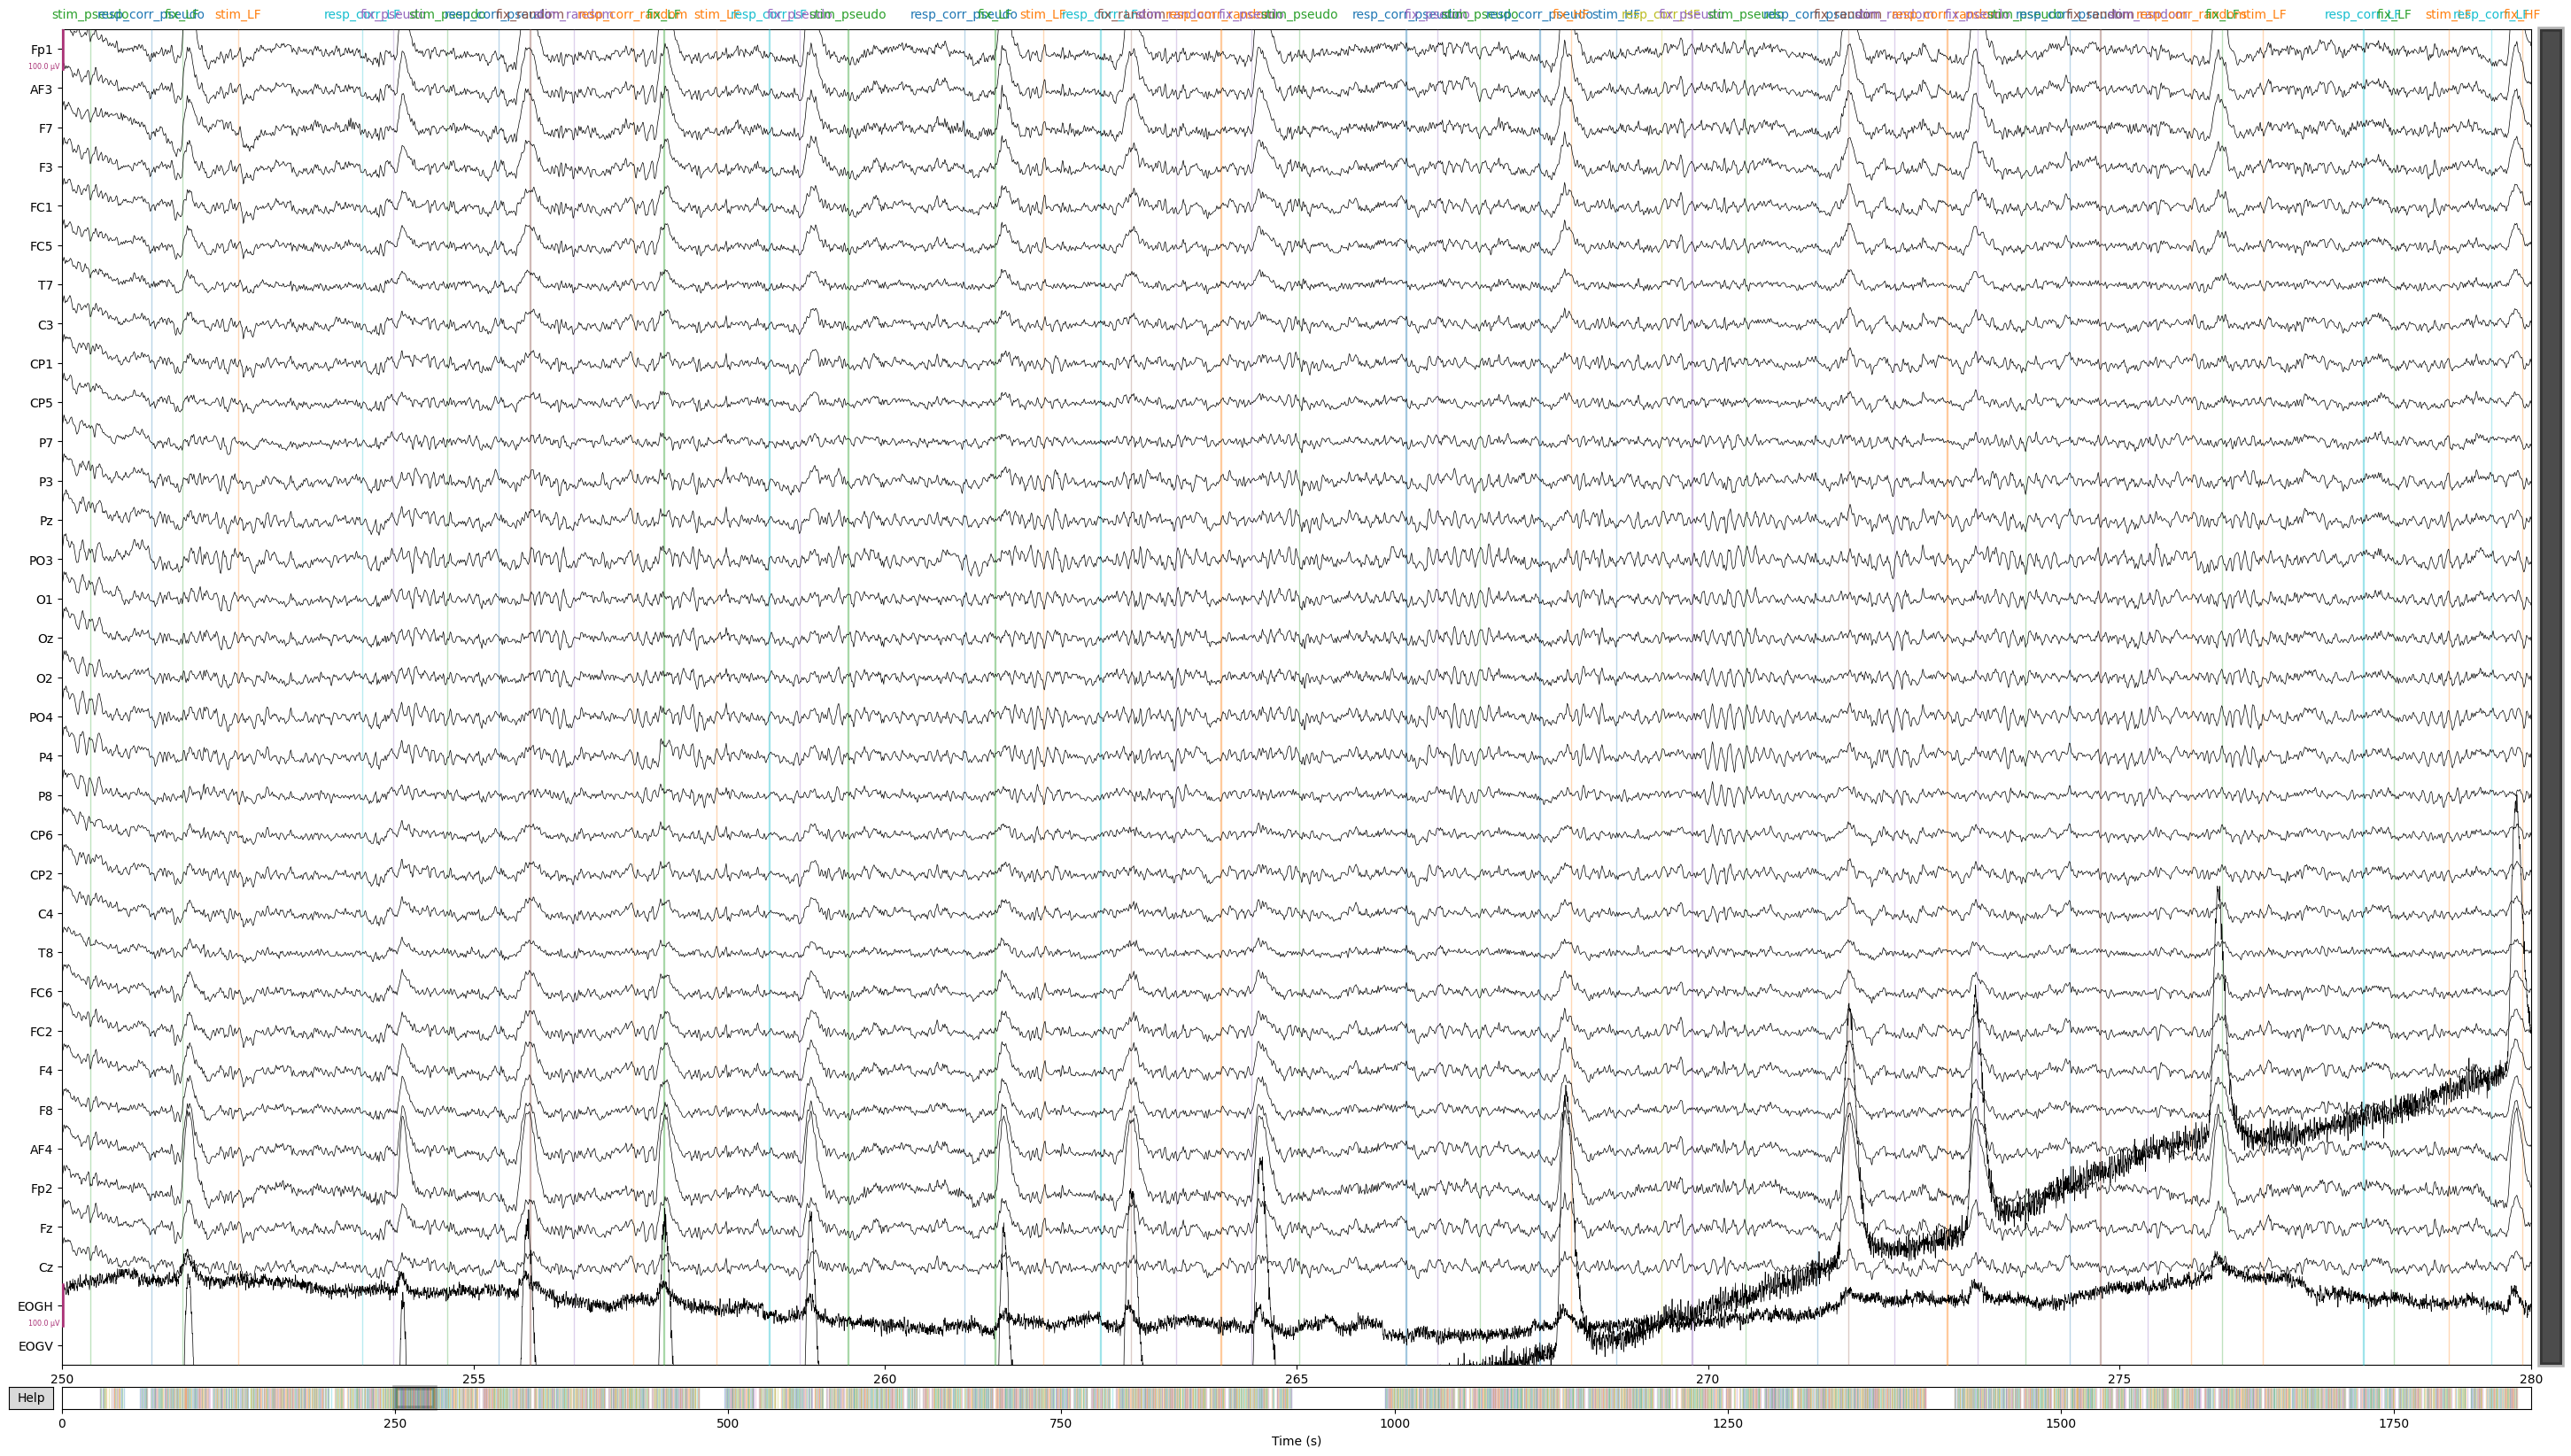

In [11]:
%matplotlib inline 
fig = raw.plot(duration=30,n_channels=len(raw.ch_names), scalings=50e-6, remove_dc=True, use_opengl=True, clipping=None, decim='auto', precompute=True, start=250)

Finally, we save the data, as we don't want to redo those steps later.

In [12]:
fname = EEG_data_path + 'filtered-' + name_subj + '_eeg.fif'
raw.save(fname, overwrite=True)

Overwriting existing file.
Writing /Users/Jelmer/Work/Vakken/MethodsCCS/MethodsCCS_2324/EEG/python_example/data/filtered-1_eeg.fif
Closing /Users/Jelmer/Work/Vakken/MethodsCCS/MethodsCCS_2324/EEG/python_example/data/filtered-1_eeg.fif
[done]


### Visual artifact inspection

In this phase, you're going through the data by hand to remove artifacts. We will look for faulty electrodes (flat, very noisy, unstable for long period of times), and noisy time windows more generally. I still prefer doing this by hand, because I haven't found a really good automatic method yet. However, there are toolboxes out there that can do this.

First, we will load the data again, in case we restart at this point.

In [13]:
raw = mne.io.read_raw(EEG_data_path + 'filtered-' + name_subj + '_eeg.fif', preload=True)
events = mne.events_from_annotations(raw,event_id=event_dict)[0]

Opening raw data file ./data/filtered-1_eeg.fif...
    Range : 0 ... 948735 =      0.000 ...  1852.998 secs
Ready.
Reading 0 ... 948735  =      0.000 ...  1852.998 secs...
Used Annotations descriptions: ['block_start', 'fix_HF', 'fix_LF', 'fix_pseudo', 'fix_random', 'practice_endblock_end', 'practice_start', 'resp_corr_HF', 'resp_corr_LF', 'resp_corr_pseudo', 'resp_corr_random', 'resp_incorr_HF', 'resp_incorr_LF', 'resp_incorr_pseudo', 'resp_incorr_random', 'resp_none_HF', 'resp_none_LF', 'resp_none_pseudo', 'stim_HF', 'stim_LF', 'stim_pseudo', 'stim_random']


Next, we mark data to-be-removed before the first block, between blocks, and after the last block, decreasing the data we have to check. This mean we have to mark everything up to the first '4' trigger, between '6' and '4' triggers, and after the last '6' trigger. 

In [14]:
#mark breaks, up to first 4, between 6 and 4 triggers, and after last 6 trigger.
events46 = events[np.isin(events[:,2],[4,6]),:] #we only care about 4's and 6's at this point

#before first, after last
onset_first = 0
duration_first = events46[0,0]*1/raw.info['sfreq'] - 1
onset_last = events46[-1,0]*1/raw.info['sfreq'] + 1
duration_last = len(raw)*1/raw.info['sfreq'] - onset_last

#between blocks
events46 = events46[1:-1,:]
onsets=[]
durations=[]
for i, ev in enumerate(events46[:-1,:]):
    if ev[2] == 6: #from end block to next start (=4)
        onsets.append(events46[i,0] * 1 / raw.info['sfreq'] + 1) #add 1 to add space after response
        durations.append((events46[i+1,0] - events46[i,0]) * 1 / raw.info['sfreq'] - 2) #subtract 2 sec to make space around trials 

#annotate as BAD_break
break_annot = mne.Annotations(onset = np.concatenate(([onset_first], [onset_last], onsets)), duration = np.concatenate(([duration_first], [duration_last], durations)), description="BAD_break", orig_time=raw.annotations.orig_time)
raw.set_annotations(raw.annotations + break_annot);

Now we can do the actual artifact rejection. Sometimes, channels are noisy or flat throughout the experiment, in those cases, we simply remove the channels. This is one reason for keeping clear notes while running an experiment: if you already know that you have a bad channel, you don't have to spend time on finding that out here. We can indicate bad channels by clicking on them in the display.

The next step is the step that takes most time, going by hand through the data to identify artifacts. However, I believe it leads to the best rejection AND it gives you a feeling for the quality of your data and potential problems. This might take up to as much time as it took to run the experiment, so 30 minutes for 30 minutes experiment. I recommend using a big screen! 

Importantly, always set the x and y scales to the same values for different participants, in order for noise to look comparable.

When the window opens, you can first enter a new annotation type, starting with BAD (because then it will be ignored later in the analysis), for example 'BAD_artifact'. Next, scroll through your data by pressing the right arrow key or shift+right+arrow, and mark parts of the data that look bad (you can ignore the red parts, those are the ones we just marked in the previous step). See also https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html, and the lecture slides. When you're done, you can safely close the window.

In [15]:
#matplotlib magic - pop up
%matplotlib qt

#visual artifact inspection
fig = raw.plot(duration=30,n_channels=len(raw.ch_names), scalings=40e-6, remove_dc=True, use_opengl=True, clipping=None, decim='auto', precompute=True)
fig.fake_keypress("a") #to do artifact rejection

And then we save again.

In [16]:
fname = EEG_data_path + 'filtered_rejected-' + name_subj + '_eeg.fif'
raw.save(fname, overwrite=True)

Overwriting existing file.
Writing /Users/Jelmer/Work/Vakken/MethodsCCS/MethodsCCS_2324/EEG/python_example/data/filtered_rejected-1_eeg.fif
Closing /Users/Jelmer/Work/Vakken/MethodsCCS/MethodsCCS_2324/EEG/python_example/data/filtered_rejected-1_eeg.fif
[done]


### Independent Component Analysis (ICA)

To remove eye artifacts we'll use independent component analysis (see MNE's tutorials, e.g. https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#sphx-glr-auto-tutorials-preprocessing-40-artifact-correction-ica-py). In the first step we are going to run the ICA itself, after loading the data.

In [19]:
from mne.preprocessing import ICA, read_ica

raw = mne.io.read_raw(EEG_data_path + 'filtered_rejected-' + name_subj + '_eeg.fif', preload=True)
 
#set up and fit the ICA
ica = ICA()
ica.fit(raw.pick('eeg'))

#save solution
ica.save(EEG_data_path + 'ica-' + name_subj + '_ica.fif', overwrite=True)

Opening raw data file ./data/filtered_rejected-1_eeg.fif...
    Range : 0 ... 948735 =      0.000 ...  1852.998 secs
Ready.
Reading 0 ... 948735  =      0.000 ...  1852.998 secs...
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Omitting 138715 of 948736 (14.62%) samples, retaining 810021 (85.38%) samples.
Selecting by non-zero PCA components: 31 components
Fitting ICA took 15.7s.
Overwriting existing file.
Writing ICA solution to /Users/Jelmer/Work/Vakken/MethodsCCS/MethodsCCS_2324/EEG/python_example/data/ica-1_ica.fif...


<ICA | raw data decomposition, method: fastica (fit in 36 iterations on 810021 samples), 31 ICA components (31 PCA components available), channel types: eeg, no sources marked for exclusion>

Now we have to judge the ICA components, and see if they are related to artifacts. The first thing we can do is automatically detect EOG-related components, based on correlation with the eye channels.

Opening raw data file ./data/filtered_rejected-1_eeg.fif...
    Range : 0 ... 948735 =      0.000 ...  1852.998 secs
Ready.
Reading 0 ... 948735  =      0.000 ...  1852.998 secs...
Reading ./data/ica-1_ica.fif ...
Now restoring ICA solution ...
Ready.
Using EOG channels: EOGH, EOGV
Omitting 138715 of 948736 (14.62%) samples, retaining 810021 (85.38%) samples.
Omitting 138715 of 948736 (14.62%) samples, retaining 810021 (85.38%) samples.
Omitting 138715 of 948736 (14.62%) samples, retaining 810021 (85.38%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter le

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

Omitting 138715 of 948736 (14.62%) samples, retaining 810021 (85.38%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)



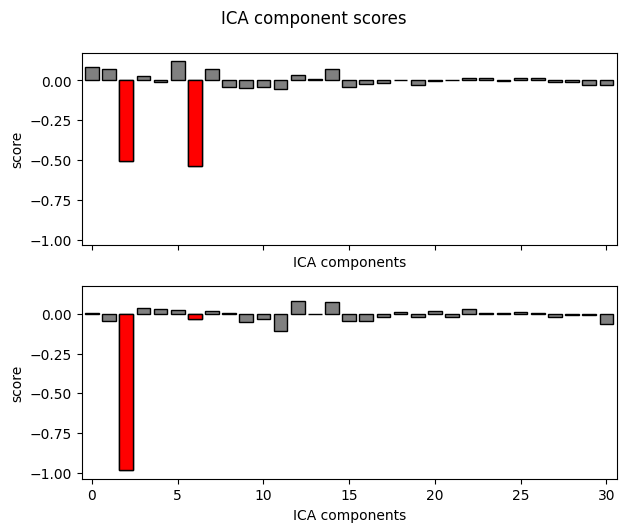

In [37]:
#load data and ICA solution
raw = mne.io.read_raw(EEG_data_path + 'filtered_rejected-' + name_subj + '_eeg.fif', preload=True);
ica = read_ica(EEG_data_path + 'ica-' + name_subj + '_ica.fif');

%matplotlib inline
ica.exclude, eog_scores = ica.find_bads_eog(raw);
fig = ica.plot_scores(eog_scores);

Apparently, component 002 and 006 are related to eye movements or blinks. Let's take a look at the components. If you open these in an interactive window (%matplotlib qt) you can click on the components you want to exclude. Here, 002 and 006 were pre-selected based on the previous step. The also very much look like eye components, so it's probably correct to remove those.

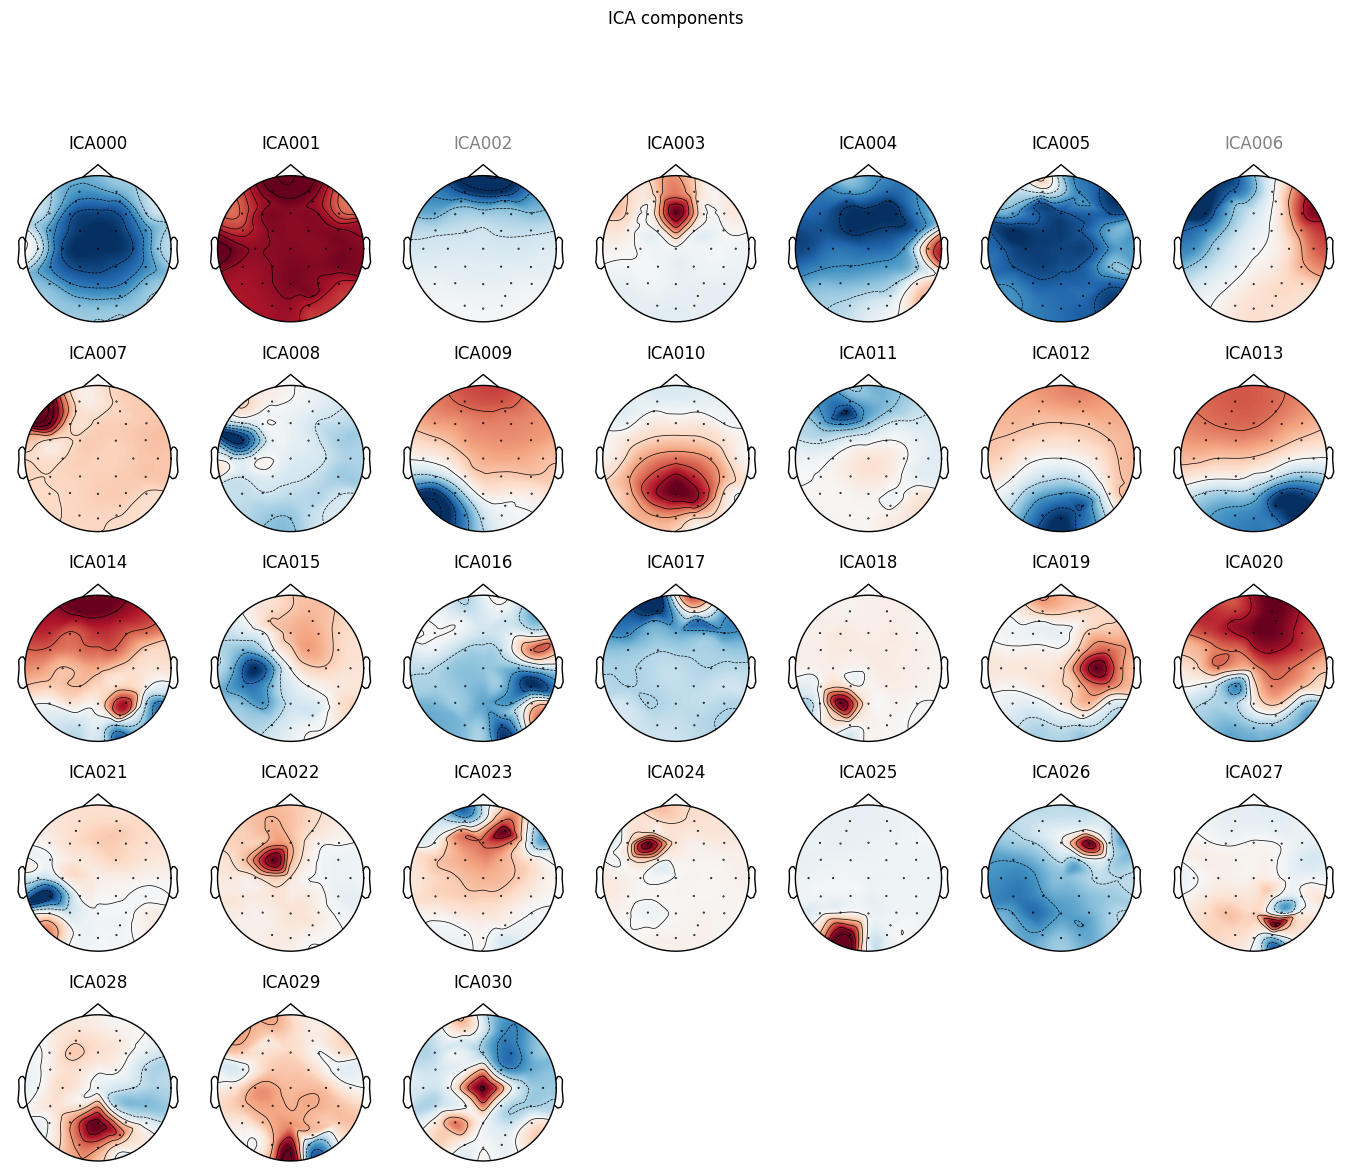

In [21]:
fig = ica.plot_components(inst=raw,nrows=5,ncols='auto')

You can check the effect of removing those components with the following commands (output not included here).

In [38]:
# copy raw to be able to compare
orig_raw = raw.copy()

#apply
ica.apply(raw)

#and check once more
%matplotlib qt

fignew = raw.plot(duration=30,n_channels=len(raw.ch_names), scalings=35e-6, remove_dc=True, use_opengl=True, clipping=None, decim='auto', precompute=True)
figori = orig_raw.plot(duration=30,n_channels=len(raw.ch_names), scalings=35e-6, remove_dc=True, use_opengl=True, clipping=None, decim='auto', precompute=True)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components


Channels marked as bad:
['PO3']
Channels marked as bad:
['PO3']


At the end, we save once again.

In [39]:
#save both raw and ica, to be able to reconstruct ica rejection later if necessary
ica.save(EEG_data_path + 'ica-' + name_subj + '_ica.fif', overwrite=True)
fname = EEG_data_path + 'filtered_rejected_ica_removed-' + name_subj + '_eeg.fif'
raw.save(fname, overwrite=True)

Overwriting existing file.
Writing ICA solution to /Users/Jelmer/Work/Vakken/MethodsCCS/MethodsCCS_2324/EEG/python_example/data/ica-1_ica.fif...
Overwriting existing file.
Writing /Users/Jelmer/Work/Vakken/MethodsCCS/MethodsCCS_2324/EEG/python_example/data/filtered_rejected_ica_removed-1_eeg.fif
Closing /Users/Jelmer/Work/Vakken/MethodsCCS/MethodsCCS_2324/EEG/python_example/data/filtered_rejected_ica_removed-1_eeg.fif
[done]


### Epoching and baselining

After cleaning our data, we can now divide it into 'epochs', or trials. We do this with the following steps:
- interpolate channels that were removed (necessary for some analyses)
- add behavioral data
- remove behavioral outliers
- epoch the data

To begin, we load the data, interpolate missing channels and keep only EEG channels.

In [40]:
#load data
raw = mne.io.read_raw(EEG_data_path + 'filtered_rejected_ica_removed-' + name_subj + '_eeg.fif', preload=True)
events = mne.events_from_annotations(raw,event_id=event_dict)[0]

#interpolate bad channels
raw.interpolate_bads()

#drop eye channels
raw.pick(['eeg'])

Opening raw data file ./data/filtered_rejected_ica_removed-1_eeg.fif...
    Range : 0 ... 948735 =      0.000 ...  1852.998 secs
Ready.
Reading 0 ... 948735  =      0.000 ...  1852.998 secs...
Used Annotations descriptions: ['block_start', 'fix_HF', 'fix_LF', 'fix_pseudo', 'fix_random', 'practice_endblock_end', 'practice_start', 'resp_corr_HF', 'resp_corr_LF', 'resp_corr_pseudo', 'resp_corr_random', 'resp_incorr_HF', 'resp_incorr_LF', 'resp_incorr_pseudo', 'resp_incorr_random', 'resp_none_HF', 'resp_none_LF', 'resp_none_pseudo', 'stim_HF', 'stim_LF', 'stim_pseudo', 'stim_random']
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors


<Raw | filtered_rejected_ica_removed-1_eeg.fif, 32 x 948736 (1853.0 s), ~231.7 MB, data loaded>

Next, we read the behavioral data as a pandas dataframe, and only keep columns that are potentially of interest.

In [41]:
#load behavior, link to events
import pandas
behav = pandas.read_csv(EEG_data_path + 'behavior_subject-' + name_subj + '.csv')

#from events, remove non-trial events (3-6) and fixations
events = events[~np.isin(events[:,2], [3,4,5,6,51,52,53,54]),:]

#check len behav * 2 = len events
if len(behav) * 2 != len(events):
    print('Different number of trials in behavior and EEG!')

varis_of_interest =  ['subj', 'block', 'condition', 'cond', 'RT', 'acc', 'out']
event_props = pandas.DataFrame(np.repeat(behav.loc[:, varis_of_interest],2,axis=0)) #make a dataframe reflecting the events
event_props.columns = varis_of_interest
event_props

subj block condition    cond    RT acc out
0       1     0         3  Pseudo  1201   1   1
1       1     0         3  Pseudo  1201   1   1
2       1     0         1      HF   573   1   1
3       1     0         1      HF   573   1   1
4       1     0         2      LF  2000   0   1
...   ...   ...       ...     ...   ...  ..  ..
1931    1     4         4  Random   560   1   0
1932    1     4         1      HF   478   1   0
1933    1     4         1      HF   478   1   0
1934    1     4         1      HF   624   1   0
1935    1     4         1      HF   624   1   0

[1936 rows x 7 columns]

For each event we have a row in the dataframe. Because we have two events per trial (stimulus and response), we have a copy of each row. We now remove events (and their properties) that are behavioral outliers or mistakes.

In [42]:
#remove behavioral outliers (coded in the 'out' column) and incorrect responses
events = events[(event_props.out == 0) & (event_props.acc == 1),:]
event_props = event_props[(event_props.out == 0) & (event_props.acc == 1)]
event_props

subj block condition    cond    RT acc out
16      1     1         3  Pseudo  1171   1   0
17      1     1         3  Pseudo  1171   1   0
18      1     1         3  Pseudo   862   1   0
19      1     1         3  Pseudo   862   1   0
22      1     1         3  Pseudo   768   1   0
...   ...   ...       ...     ...   ...  ..  ..
1931    1     4         4  Random   560   1   0
1932    1     4         1      HF   478   1   0
1933    1     4         1      HF   478   1   0
1934    1     4         1      HF   624   1   0
1935    1     4         1      HF   624   1   0

[1778 rows x 7 columns]

We now have about a 150 row less, so 150/2 = 75 trials removed, of the ~960 we started with. That is reasonable based on behavior.

Next, we are going to epoch and baseline the data. This is done in two steps:
- first we epoch just to see which trials are incomplete due to missing EEG data (because of artifacts). This information is collected and used to remove all trials that are missing in any of these data sets.
- next, we redo this with trials that are present in all data set. We first collect the baseline (-200-0 ms before the stimulus). Next, we make the stimulus-locked and response-locked epochs, and apply the baseline.

In [43]:
#find missing data

#NOTE that this needs to be done twice, because they do not necessarily overlap,
#epoch stim-locked (200 ms baseline given the short itis)
stim_events = [11, 12, 13, 14]
resp_events = [21, 22, 23, 24] #only 20-s, because rest is already removed

stim = {key: value for key, value in event_dict.items() if value in stim_events}
epochs = mne.Epochs(raw, events[np.isin(events[:,2],stim_events),:], event_id=stim, tmin=-0.2, tmax=.8, preload=True, baseline=None,reject=dict(eeg=100e-6))
drops = np.array([True if tmp != () else False for tmp in epochs.drop_log])

#epoch response-locked 
resp = {key: value for key, value in event_dict.items() if value in resp_events}
epochs = mne.Epochs(raw, events[np.isin(events[:,2],resp_events),:], event_id=resp, tmin=-0.8, tmax=.2, preload=True, baseline=None,reject=dict(eeg=100e-6))
drops = drops | np.array([True if tmp != () else False for tmp in epochs.drop_log])

#log epochs drop
behav['eeg_drops'] = 0
behav.loc[(behav.out == 0) & (behav.acc == 1),'eeg_drops'] = drops.astype(int)

#store this in event_props
event_props['eeg_drops'] = np.repeat(drops.astype(int),2)
events = events[event_props.eeg_drops == 0,:]
event_props = event_props[event_props.eeg_drops == 0]
behav = behav[(behav.out == 0) & (behav.acc ==1) & (behav.eeg_drops==0)]


Not setting metadata
889 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 889 events and 513 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'O1', 'Oz', 'O2', 'PO4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6

/var/folders/rj/hyjtdrps62x6nxdvfkpgt4mm0000gp/T/ipykernel_60627/2526530599.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_props['eeg_drops'] = np.repeat(drops.astype(int),2)


Both the response-locked and stimulus-locked data drop 77 epoch due to artifacts. This information is stored, and we can now do the final epoching:

In [44]:
#get baseline
stim = {key: value for key, value in event_dict.items() if value in stim_events}
epochs_base = mne.Epochs(raw, events[np.isin(events[:,2],stim_events),:], event_id=stim, tmin=-0.2, tmax=0, preload=True, baseline=None)
baselines = epochs_base.get_data()
baselines = np.mean(baselines,2)

#epoch stim-locked & apply baseline
epochs_stim = mne.Epochs(raw, events[np.isin(events[:,2],stim_events),:], event_id=stim, tmin=-0.2, tmax=.8, preload=True, baseline=None, metadata=behav)
epochs_stim._data = epochs_stim._data - np.tile(baselines[:,:,np.newaxis], (1,1,epochs_stim._data.shape[2]))

#epoch response-locked & apply baseline
resp = {key: value for key, value in event_dict.items() if value in resp_events}
epochs_resp = mne.Epochs(raw, events[np.isin(events[:,2],resp_events),:], event_id=resp, tmin=-0.8, tmax=.2, preload=True, baseline=None, metadata=behav)
epochs_resp._data = epochs_resp._data - np.tile(baselines[:,:,np.newaxis], (1,1,epochs_resp._data.shape[2]))

Not setting metadata
810 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 810 events and 103 original time points ...
0 bad epochs dropped
Adding metadata with 15 columns
810 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 810 events and 513 original time points ...
0 bad epochs dropped
Adding metadata with 15 columns
810 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 810 events and 513 original time points ...
0 bad epochs dropped


One neat feature of MNE is that you can include the behavioral data in the epoched dataset.

In [45]:
print(epochs_stim)
epochs_stim.metadata

<Epochs |  810 events (all good), -0.199219 – 0.800781 s, baseline off, ~101.5 MB, data loaded, with metadata,
 'stim_HF': 210
 'stim_LF': 187
 'stim_pseudo': 198
 'stim_random': 215>


subj practice  block  condition    cond  stimulus correct_response  \
0       1       No      1          2      LF   leegten                n   
1       1       No      1          1      HF      arme                n   
2       1       No      1          3  Pseudo     hoogd                m   
3       1       No      1          4  Random   nfekufl                m   
4       1       No      1          4  Random   laetrir                m   
..    ...      ...    ...        ...     ...       ...              ...   
805     1       No      4          1      HF      been                n   
806     1       No      4          2      LF   griepje                n   
807     1       No      4          4  Random   sgnjaor                m   
808     1       No      4          4  Random  sutilpor                m   
809     1       No      4          1      HF     ermee                n   

    response  fixation_dur   RT  acc       RTz  out  trial  eeg_drops  
0          n           403  738    1  0.279369    0     17          0  
1          n           530  826    1  0.894762    0     18          0  
2          m           424  961    1  1.434488    0     24          0  
3          m           552  705    1  0.587345    0     25          0  
4          m           407  559    1 -0.141621    0     26          0  
..       ...           ...  ...  ...       ...  ...    ...        ...  
805        n           453  509    1 -0.523406    0    955          0  
806        n           511  490    1 -0.954628    0    956          0  
807        m           545  414    1 -0.865594    0    957          0  
808        m           397  560    1 -0.136628    0    958          0  
809        n           575  478    1 -0.662091    0    959          0  

[810 rows x 15 columns]

So we have about 200 trials per condition here, and all details are stored in epochs_stim.metadata.

Of course, we save this once again.

In [46]:
epochs_stim.save(EEG_data_path + 'epochs_stim-' + name_subj + '_epo.fif', overwrite=True)
epochs_resp.save(EEG_data_path + 'epochs_resp-' + name_subj + '_epo.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


## Event-Related Potentials

Now it is finally time to plot! I will demonstrate how to make event-related potentials, the classical way to analyze EEG data. The code might seem a bit complex, but that is because it should be able to deal with multiple participants directly. For more info, see https://mne.tools/stable/auto_tutorials/evoked/30_eeg_erp.html.

First we set up our environment:

In [47]:
import mne # preprocessing and plotting
import numpy as np # numerical computations
import matplotlib.pyplot as plt # plotting

# plot within notebook, useful for later sharing
%matplotlib inline 

EEG_data_path = './data/' # might be different on Windows

names_subjs = ["1"] #now as list, to be able to deal with multiple subjects
nsubs = len(names_subjs)

Next we load the data:

In [48]:
epochs_stim = []
epochs_resp = []

#load data
for subj in names_subjs:
    epochs_stim.append(mne.read_epochs(EEG_data_path + 'epochs_stim-' + subj + '_epo.fif', preload=True))
    epochs_resp.append(mne.read_epochs(EEG_data_path + 'epochs_resp-' + subj + '_epo.fif', preload=True)) 


Reading /Users/Jelmer/Work/Vakken/MethodsCCS/MethodsCCS_2324/EEG/python_example/data/epochs_stim-1_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     800.78 ms
        0 CTF compensation matrices available
Adding metadata with 15 columns
810 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/Jelmer/Work/Vakken/MethodsCCS/MethodsCCS_2324/EEG/python_example/data/epochs_resp-1_epo.fif ...
    Found the data of interest:
        t =    -800.78 ...     199.22 ms
        0 CTF compensation matrices available
Adding metadata with 15 columns
810 matching events found
No baseline correction applied
0 projection items activated


Here I will only make stimulus-locked ERPs, but obviously response-locked ERPs can be made similarly. The next step is to average within subject by condition. Again, this is a bit overkill for one subject, but should be helpful when you have more than one.

In [49]:
conds = ['stim_HF', 'stim_LF', 'stim_pseudo', 'stim_random'] 

evokeds_cond= []
evokeds_subject_avg = []
for c in conds:
    
    #collect subject averages
    evoked_subj = []
    for subj in range(nsubs):
        evoked_subj.append(epochs_stim[subj][c].average()) #take average over selection (per condition)

    #store subj averages as list by cond
    evokeds_subject_avg.append(evoked_subj)

    #take grand average
    evokeds_cond.append(mne.combine_evoked(evoked_subj, weights='equal'))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Here I use the original event names that were used to analyze the data. However, you can also use the metadata, making it easy to make other selections. See https://mne.tools/stable/auto_tutorials/epochs/30_epochs_metadata.html.

Next, we can make different kinds of plots, starting with a single condition:

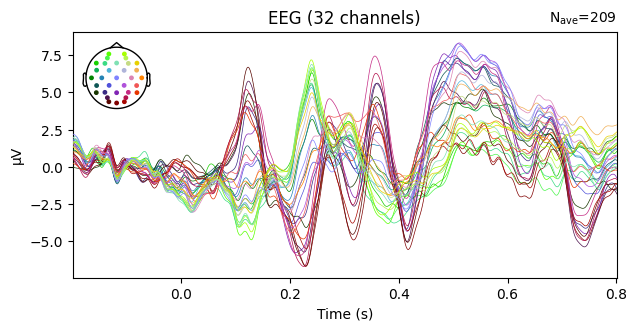

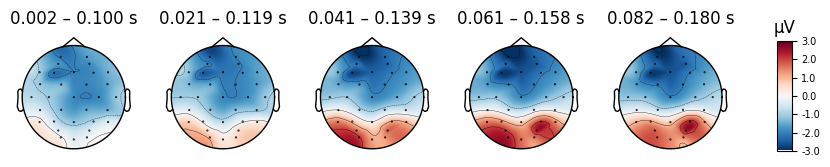

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


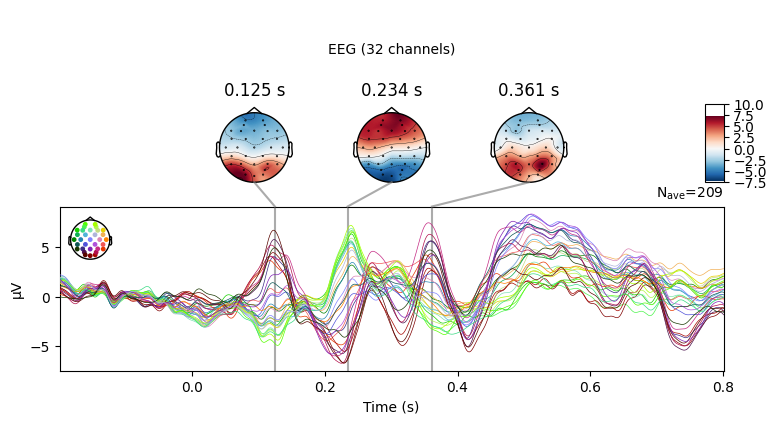

In [50]:
# change list into dictionary to make life easier down the line
evks = dict(zip(conds, evokeds_cond))

%matplotlib inline
evks['stim_HF'].plot(spatial_colors=True); #all channels
evks['stim_HF'].plot_topomap(times=np.linspace(.05,.13,5),colorbar=True, average=0.1); #topo plots
evks['stim_HF'].plot_joint(); #combination

More interesting is often to compare conditions.

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/rj/hyjtdrps62x6nxdvfkpgt4mm0000gp/T/ipykernel_60627/1332903155.py:3: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evks,picks=['Cz'], time_unit='ms',combine='mean', show_sensors=True)


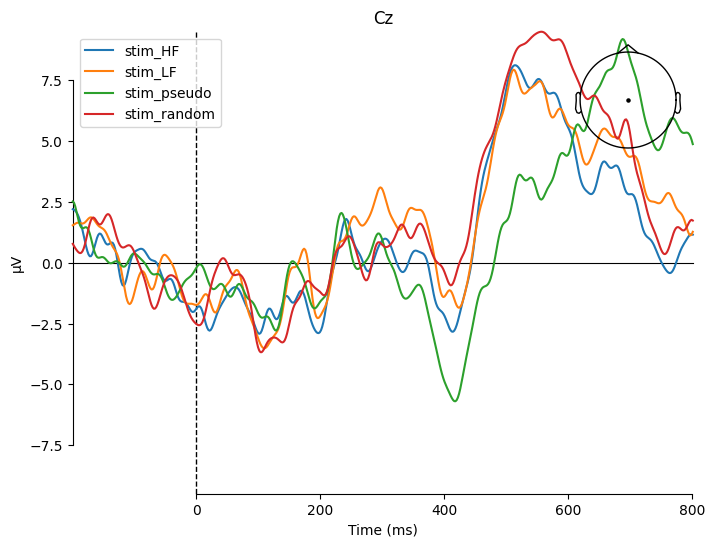

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


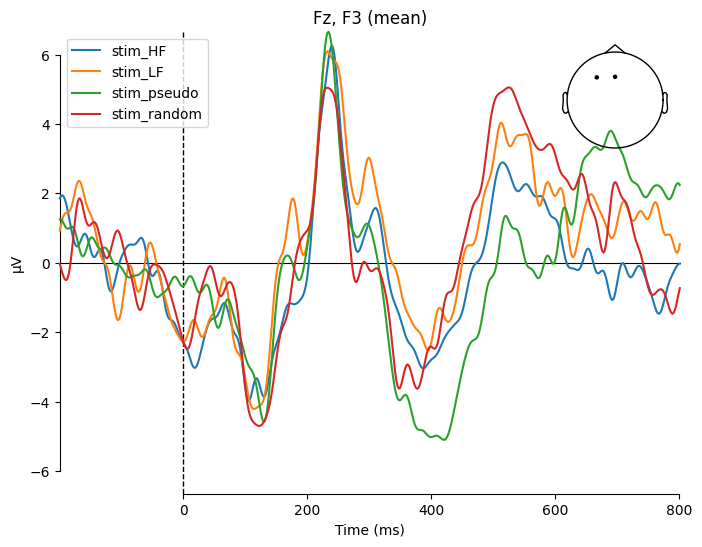

[<Figure size 800x600 with 2 Axes>]

In [51]:
#compare conditions
#parietal Cz
mne.viz.plot_compare_evokeds(evks,picks=['Cz'], time_unit='ms',combine='mean', show_sensors=True)

#averaging across to frontal channels
mne.viz.plot_compare_evokeds(evks,picks=['Fz','F3'], time_unit='ms',combine='mean', show_sensors=True)

In this dataset there are already clear effects with a single subject.

One thing that is often nice to do is plot the overview of all channels, and click on the ones your interested in to zoom in.

In [52]:
%matplotlib qt
mne.viz.plot_compare_evokeds(evks,axes='topo', time_unit='ms')

[<Figure size 3600x2800 with 33 Axes>]

If you want to learn more about plotting, see: https://mne.tools/stable/auto_tutorials/evoked/20_visualize_evoked.html#sphx-glr-auto-tutorials-evoked-20-visualize-evoked-py.